1. human TMAについて、四十物先生からアノテーションをいただいたので、ざっと確認する。
2. メタデータを合わせて画像を可視化する

NOTE: 全てにアノテーションができているわけではないことに注意

In [1]:
import numpy as np
import pandas as pd
import sys

from eda import git_root

In [2]:
ROOT = git_root(absolute=True)

In [3]:
df_meta = pd.read_csv(ROOT / "data/submission/meta/human_tma_20220112.csv", index_col=0)
df_meta["sex"].replace("F", "Female", inplace=True)
df_meta["sex"].replace("M", "Male", inplace=True)
df_meta.head()

,map,TMA_ID,Unknown,age,sex,Organ,Diagnosis,pTNM
0,1,09D13929,A4,69,Male,Liver,Intrahepatic cholangiocarcinoma,"pT1, pNx, pMx, R0"
1,2,09D13929,A4,69,Male,Liver,Intrahepatic cholangiocarcinoma,"pT1, pNx, pMx, R0"
2,3,09D15269,D5,64,Male,Liver,Intrahepatic cholangiocarcinoma,"T4, N1, Mx, R1"
3,4,09D15269,D5,64,Male,Liver,Intrahepatic cholangiocarcinoma,"T4, N1, Mx, R1"
4,5,09D16005,B1,70,Male,Liver,primary hepatic cholangiocarcinoma.,The tumour extends upto the capsule of the liv...


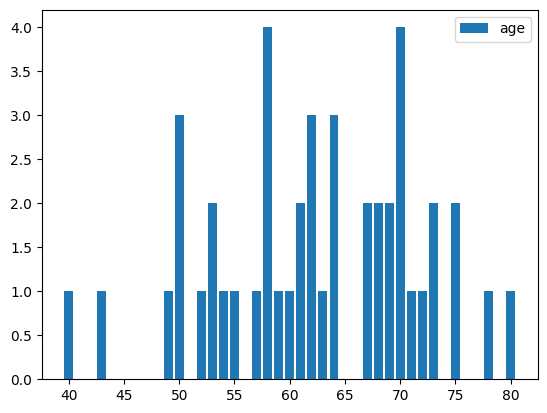

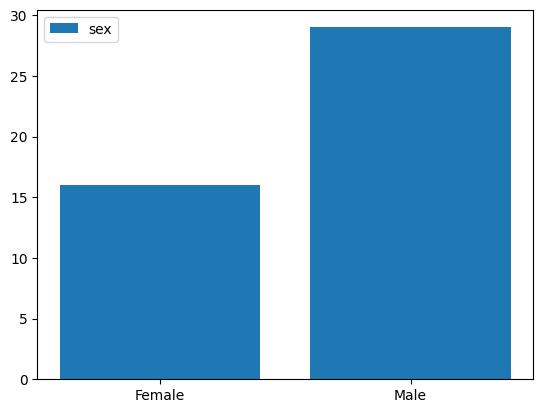

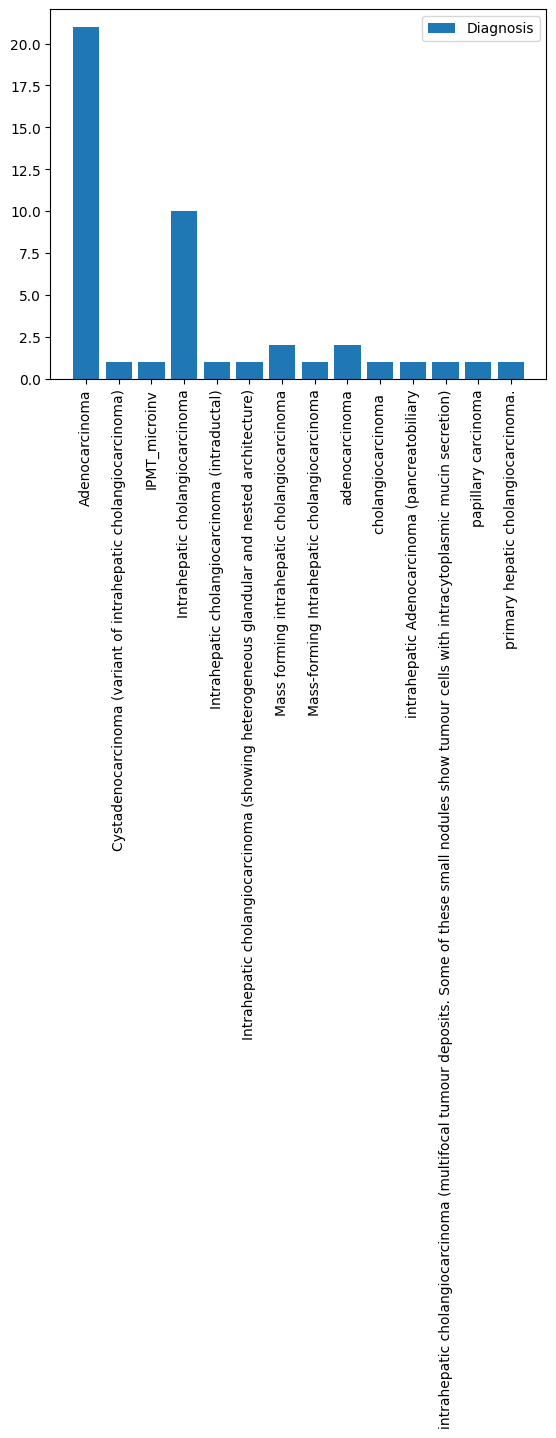

In [4]:
import matplotlib.pyplot as plt
_df_meta = df_meta.drop_duplicates(["TMA_ID"])

plt.figure()
groups_age = _df_meta.groupby("age").count().max(axis=1)
plt.bar(groups_age.index, groups_age, label="age")
plt.legend()

plt.figure()
groups_age = _df_meta.groupby("sex").count().max(axis=1)
plt.bar(groups_age.index, groups_age, label="sex")
plt.legend()

fig, ax = plt.subplots(1, 1)
groups_age = _df_meta.groupby("Diagnosis").count().max(axis=1)
ax.bar(groups_age.index, groups_age, label="Diagnosis")
ax.tick_params(axis='x', labelrotation=90)
ax.legend()

In [5]:
import re


def _clean_pT(x):
    m = re.match("(.+|^)(T[\d]|Tx)", x)
    if m:
        return m.group(2)
    return "Unknown"

def _clean_pN(x):
    m = re.match("(.+|^)(N[\d]|Nx)", x)
    if m:
        return m.group(2)
    return "Unknown"

def _clean_pM(x):
    m = re.match("(.+|^)(M[\d]|Mx)", x)
    if m:
        return m.group(2)
    return "Unknown"

_df_meta = (_df_meta.assign(T=_df_meta["pTNM"].apply(lambda x: _clean_pT(x)))
                    .assign(N=_df_meta["pTNM"].apply(lambda x: _clean_pN(x)))
                    .assign(M=_df_meta["pTNM"].apply(lambda x: _clean_pM(x))))
_df_meta.head()

,map,TMA_ID,Unknown,age,sex,Organ,Diagnosis,pTNM,T,N,M
0,1,09D13929,A4,69,Male,Liver,Intrahepatic cholangiocarcinoma,"pT1, pNx, pMx, R0",T1,Nx,Mx
2,3,09D15269,D5,64,Male,Liver,Intrahepatic cholangiocarcinoma,"T4, N1, Mx, R1",T4,N1,Mx
4,5,09D16005,B1,70,Male,Liver,primary hepatic cholangiocarcinoma.,The tumour extends upto the capsule of the liv...,Unknown,Unknown,Unknown
6,7,10D20720,B8,73,Female,Liver,intrahepatic cholangiocarcinoma (multifocal tu...,"pT3, G2, V1, Pne1, R0, Mx",T3,Unknown,Mx
8,9,11D38638,E4,64,Male,Liver,Intrahepatic cholangiocarcinoma,"TNM 7, pT3, N1, Mx, G1,V1, Pn1, R1",T3,N1,Mx


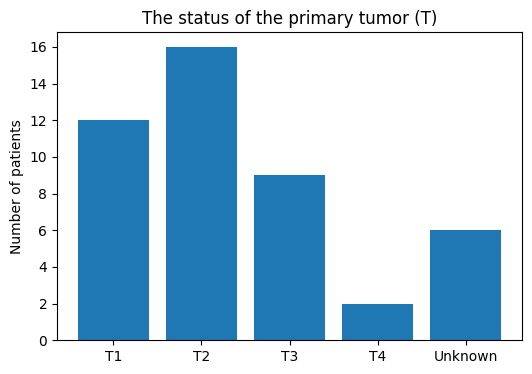

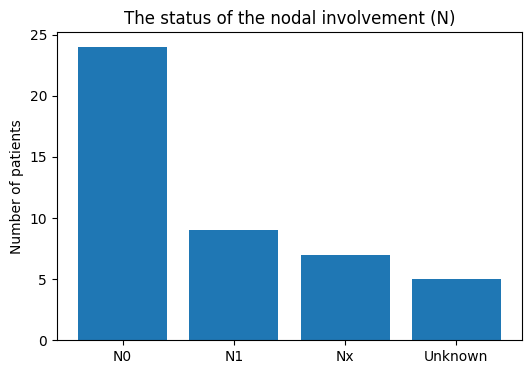

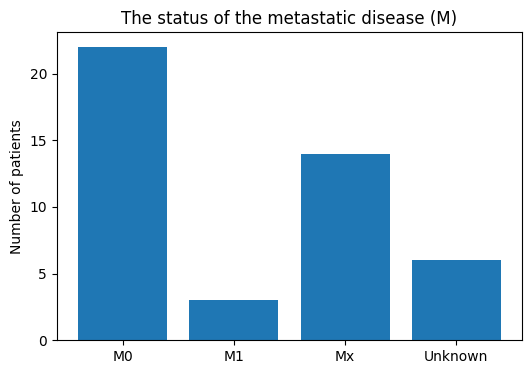

In [6]:
titles = ["primary tumor (T)", "nodal involvement (N)", "metastatic disease (M)"]
classes = "TNM"
for (klass, title) in zip(classes, titles):
    x, y = np.unique(_df_meta[klass], return_counts=True)
    plt.figure(figsize=(6, 4))
    plt.bar(x, y, label=f"p{klass}")
    # plt.legend()
    plt.title(f"The status of the {title}")
    plt.ylabel("Number of patients")
    plt.show()

In [7]:
def stage(T, N, M):
    """UICC 7th edition.
    Intrahepatic bile duct cancer.
    """
    Ts = ["T1", "T2", "T3", "T4"]
    Ns = ["N0", "N1"]
    
    if M == "M1":
        return "IV-B"
    elif N == "N1":
        return "IV-A"
    elif T == "T1":
        return "I"
    elif T == "T2":
        return "II"
    elif T == "T3":
        return "III"
    elif T == "T4":
        return "IV-A"
    return "Unknown"

In [8]:
stages = [stage(*(_df_meta.iloc[i].loc["T":"M"])) for i in range(_df_meta.shape[0])]
_df_meta = _df_meta.assign(stage=stages)
_df_meta.head()

,map,TMA_ID,Unknown,age,sex,Organ,Diagnosis,pTNM,T,N,M,stage
0,1,09D13929,A4,69,Male,Liver,Intrahepatic cholangiocarcinoma,"pT1, pNx, pMx, R0",T1,Nx,Mx,I
2,3,09D15269,D5,64,Male,Liver,Intrahepatic cholangiocarcinoma,"T4, N1, Mx, R1",T4,N1,Mx,IV-A
4,5,09D16005,B1,70,Male,Liver,primary hepatic cholangiocarcinoma.,The tumour extends upto the capsule of the liv...,Unknown,Unknown,Unknown,Unknown
6,7,10D20720,B8,73,Female,Liver,intrahepatic cholangiocarcinoma (multifocal tu...,"pT3, G2, V1, Pne1, R0, Mx",T3,Unknown,Mx,III
8,9,11D38638,E4,64,Male,Liver,Intrahepatic cholangiocarcinoma,"TNM 7, pT3, N1, Mx, G1,V1, Pn1, R1",T3,N1,Mx,IV-A


Text(0.5, 1.0, 'Cancer stage')

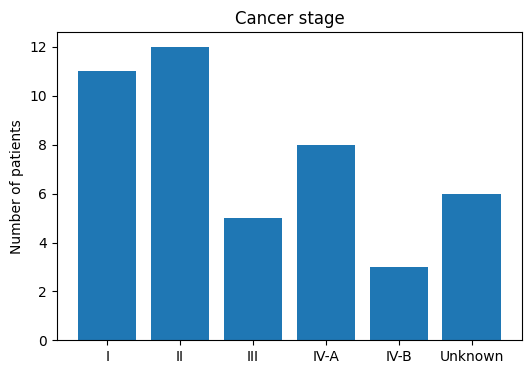

In [9]:
x, y = np.unique(_df_meta["stage"], return_counts=True)
plt.figure(figsize=(6, 4))
plt.bar(x, y, label="stage")
# plt.legend()
plt.ylabel("Number of patients")
plt.title("Cancer stage")
